In [1]:
import os
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import os 
# importing geopy library and Nominatim class
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut 
import geopandas as gpd
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import time
from shapely.geometry import Point
from shapely.ops import nearest_points

/Users/roosfens/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## First steps:

In [2]:
# Leesbaar maken van dataset 
file_path = 'duodata01.csv'
data = pd.read_csv(file_path, delimiter=';')
print(data.head())

   PROVINCIE  BEVOEGD GEZAG NUMMER INSTELLINGSCODE VESTIGINGSCODE  \
0  Flevoland                 30357            26RK         26RK00   
1  Flevoland                 30709            23FD         23FD01   
2  Flevoland                 40077            24EJ         24EJ00   
3  Flevoland                 40077            28BL         28BL00   
4  Flevoland                 40114            12PM         12PM00   

                     VESTIGINGSNAAM       STRAATNAAM HUISNUMMER-TOEVOEGING  \
0      RK Basisschool De Toermalijn             Jade                    49   
1                Shri Laksmi School    Regentesseweg                     1   
2  Islamitische Basisschool Al Iman  Harderwijkoever                     3   
3                         Al-Ihsaan            Schor                     7   
4                Basisschool De Ark        Middenhof                   210   

  POSTCODE PLAATSNAAM  GEMEENTENUMMER  ... RPA-GEBIED NAAM WGR-GEBIED CODE  \
0  3893 EB   ZEEWOLDE              50 

In [3]:
# maken van extra kolom "adress" in dataset 
filtered_data = data[data['GEMEENTENAAM'].isin(['AMSTERDAM'])]
filtered_data['ADRESS']= filtered_data['STRAATNAAM'] + ' ' + filtered_data['HUISNUMMER-TOEVOEGING'].astype(str) + ', ' + filtered_data['POSTCODE'] + ' ' + filtered_data['PLAATSNAAM'] 

print(filtered_data)

          PROVINCIE  BEVOEGD GEZAG NUMMER INSTELLINGSCODE VESTIGINGSCODE  \
202   Noord-Holland                 20970            04IU         04IU00   
203   Noord-Holland                 21464            04JA         04JA00   
204   Noord-Holland                 23440            04JS         04JS00   
226   Noord-Holland                 28614            07JK         07JK00   
227   Noord-Holland                 28614            08VA         08VA00   
...             ...                   ...             ...            ...   
986   Noord-Holland                 81810            07XC         07XC00   
1015  Noord-Holland                 94433            08CB         08CB00   
1016  Noord-Holland                 94433            09DD         09DD00   
1017  Noord-Holland                 94433            32BG         32BG00   
1018  Noord-Holland                 94459            05VP         05VP00   

                                    VESTIGINGSNAAM           STRAATNAAM  \
202         

/var/folders/c4/d1hjy4hs55z494dzspybl0br0000gn/T/ipykernel_6933/3913635300.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['ADRESS']= filtered_data['STRAATNAAM'] + ' ' + filtered_data['HUISNUMMER-TOEVOEGING'].astype(str) + ', ' + filtered_data['POSTCODE'] + ' ' + filtered_data['PLAATSNAAM']


## Longitude & Latitude 

In [4]:
# Zorg ervoor dat je 'filtered_data' hebt gedefinieerd als een pandas DataFrame
# Example: filtered_data = pd.DataFrame({'ADRESS': ['Address1', 'Address2']})

# Initialiseer de Nominatim-geocoder
loc = Nominatim(user_agent="Geopy_Library", timeout=10)  # Timeout verhoogd naar 10 seconden

latitudes = []
longitudes = []

def geocode_address(address):
    """Probeer een adres te geocoderen met foutafhandeling en retries."""
    try:
        location = loc.geocode(address)
        return location
    except GeocoderTimedOut:
        print(f"Timeout voor adres: {address}. Opnieuw proberen...")
        return geocode_address(address)  # Probeer opnieuw bij timeout
    except Exception as e:
        print(f"Fout bij geocoderen van {address}: {e}")
        return None

for address in filtered_data['ADRESS']:
    # Voeg een vertraging toe om overbelasting van de server te voorkomen
    time.sleep(1)  # Wacht 1 seconde tussen verzoeken

    # Geocode het adres
    location = geocode_address(address)
    
    # Controleer of er een locatie is gevonden
    if location:
        latitudes.append(location.latitude)
        longitudes.append(location.longitude)
    else:
        latitudes.append(None)
        longitudes.append(None)

# Voeg de resultaten toe aan de DataFrame
filtered_data['latitude'] = latitudes
filtered_data['longitude'] = longitudes

# Debug output: controleer een voorbeeldadres
# Uncomment voor extra debug informatie
# getLoc = geocode_address(filtered_data['ADRESS'][0])
# if getLoc:
#     print("Address:", getLoc.address)
#     print("Latitude:", getLoc.latitude)
#     print("Longitude:", getLoc.longitude)

# Controleer de uiteindelijke DataFrame
filtered_data


/var/folders/c4/d1hjy4hs55z494dzspybl0br0000gn/T/ipykernel_6933/2389180841.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['latitude'] = latitudes
/var/folders/c4/d1hjy4hs55z494dzspybl0br0000gn/T/ipykernel_6933/2389180841.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['longitude'] = longitudes


,PROVINCIE,BEVOEGD GEZAG NUMMER,INSTELLINGSCODE,VESTIGINGSCODE,VESTIGINGSNAAM,STRAATNAAM,HUISNUMMER-TOEVOEGING,POSTCODE,PLAATSNAAM,GEMEENTENUMMER,...,COROPGEBIED CODE,COROPGEBIED NAAM,ONDERWIJSGEBIED CODE,ONDERWIJSGEBIED NAAM,RMC-REGIO CODE,RMC-REGIO NAAM,VAKANTIEREGIO,ADRESS,latitude,longitude
202,Noord-Holland,20970,04IU,04IU00,ASVO,Frederiksplein,37,1017 XL,AMSTERDAM,363,...,23,Groot-Amsterdam,15,Zuid-Noord-Holland,21,Agglomeratie Amsterdam,Noord,"Frederiksplein 37, 1017 XL AMSTERDAM",52.360848,4.901005
203,Noord-Holland,21464,04JA,04JA00,Basisschool Rosj Pina,Nieuw Herlaer,18-20,1083 BD,AMSTERDAM,363,...,23,Groot-Amsterdam,15,Zuid-Noord-Holland,21,Agglomeratie Amsterdam,Noord,"Nieuw Herlaer 18-20, 1083 BD AMSTERDAM",52.325557,4.887659
204,Noord-Holland,23440,04JS,04JS00,Schoolvereniging Willemspark,Willem Witsenstraat,12,1077 AZ,AMSTERDAM,363,...,23,Groot-Amsterdam,15,Zuid-Noord-Holland,21,Agglomeratie Amsterdam,Noord,"Willem Witsenstraat 12, 1077 AZ AMSTERDAM",52.351090,4.869806
226,Noord-Holland,28614,07JK,07JK00,Eerste Openluchtschool voor het Gezonde Kind,Cliostraat,40,1077 KJ,AMSTERDAM,363,...,23,Groot-Amsterdam,15,Zuid-Noord-Holland,21,Agglomeratie Amsterdam,Noord,"Cliostraat 40, 1077 KJ AMSTERDAM",52.347820,4.874398
227,Noord-Holland,28614,08VA,08VA00,Tweede Openluchtschool voor het Gezonde Kind,Fred. Roeskestraat,76,1076 ED,AMSTERDAM,363,...,23,Groot-Amsterdam,15,Zuid-Noord-Holland,21,Agglomeratie Amsterdam,Noord,"Fred. Roeskestraat 76, 1076 ED AMSTERDAM",52.341726,4.863804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
986,Noord-Holland,81810,07XC,07XC00,Hildebrand Van Loonschool,Hondecoeterstraat,6,1071 LR,AMSTERDAM,363,...,23,Groot-Amsterdam,15,Zuid-Noord-Holland,21,Agglomeratie Amsterdam,Noord,"Hondecoeterstraat 6, 1071 LR AMSTERDAM",52.354620,4.877676
1015,Noord-Holland,94433,08CB,08CB00,Vrije Schoolgemeenschap Geert Groote School,Hygieaplein,47,1076 RS,AMSTERDAM,363,...,23,Groot-Amsterdam,15,Zuid-Noord-Holland,21,Agglomeratie Amsterdam,Noord,"Hygieaplein 47, 1076 RS AMSTERDAM",52.347723,4.864429
1016,Noord-Holland,94433,09DD,09DD00,Geert Groote School,Fred. Roeskestraat,82,1076 ED,AMSTERDAM,363,...,23,Groot-Amsterdam,15,Zuid-Noord-Holland,21,Agglomeratie Amsterdam,Noord,"Fred. Roeskestraat 82, 1076 ED AMSTERDAM",52.341738,4.862802
1017,Noord-Holland,94433,32BG,32BG00,Vrije School Thula,Obiplein,115,1094 RB,AMSTERDAM,363,...,23,Groot-Amsterdam,15,Zuid-Noord-Holland,21,Agglomeratie Amsterdam,Noord,"Obiplein 115, 1094 RB AMSTERDAM",52.360467,4.938811


## Defining neighborhood boundaries

In [5]:
shp_map = gpd.read_file('/Users/roosfens/Library/CloudStorage/OneDrive-Persoonlijk/documenten/UVA/Jaar 5/Afstudeer Project/Python/cbsgebiedsindelingen2023.gpkg', layer='buurt_gegeneraliseerd')
shp_map.head()

,statcode,jrstatcode,statnaam,gm_code,rubriek,id,geometry
0,BU00340101,2023BU00340101,Centrum Haven Noord,GM0034,buurt,1,"MULTIPOLYGON (((143508.204 483344.282, 143707...."
1,BU00340102,2023BU00340102,Centrum Haven Zuid,GM0034,buurt,2,"MULTIPOLYGON (((143728.650 483029.012, 143730...."
2,BU00340201,2023BU00340201,Rozenwerf en Tuinderswerf,GM0034,buurt,3,"MULTIPOLYGON (((144118.020 483591.859, 144295...."
3,BU00340202,2023BU00340202,Achterwerf,GM0034,buurt,4,"MULTIPOLYGON (((144427.109 483263.953, 144384...."
4,BU00340203,2023BU00340203,Goedewerf en Wittewerf,GM0034,buurt,5,"MULTIPOLYGON (((144267.821 483312.403, 144090...."


In [6]:
shp_map = shp_map.to_crs('EPSG:4289')
shp_map.crs

<Geographic 2D CRS: EPSG:4289>
Name: Amersfoort
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Netherlands - onshore, including Waddenzee, Dutch Wadden Islands and 12-mile offshore coastal zone.
- bounds: (3.2, 50.75, 7.22, 53.7)
Datum: Amersfoort
- Ellipsoid: Bessel 1841
- Prime Meridian: Greenwich

In [7]:
#neighborhood shp of amsterdam (alm)
shp_ams = shp_map[shp_map['gm_code'] == 'GM0363'].reset_index(drop=True)
shp_ams.head()

,statcode,jrstatcode,statnaam,gm_code,rubriek,id,geometry
0,BU0363AA01,2023BU0363AA01,Planciusbuurt-Noord,GM0363,buurt,9737,"MULTIPOLYGON (((4.88611 52.38918, 4.88443 52.3..."
1,BU0363AA02,2023BU0363AA02,Westelijke eilanden,GM0363,buurt,9738,"MULTIPOLYGON (((4.89054 52.38341, 4.89051 52.3..."
2,BU0363AA03,2023BU0363AA03,Westerdokseiland,GM0363,buurt,9739,"MULTIPOLYGON (((4.89660 52.38666, 4.89913 52.3..."
3,BU0363AA04,2023BU0363AA04,Planciusbuurt-Zuid,GM0363,buurt,9740,"MULTIPOLYGON (((4.88443 52.38668, 4.88428 52.3..."
4,BU0363AA05,2023BU0363AA05,Haarlemmerbuurt-West,GM0363,buurt,9741,"MULTIPOLYGON (((4.89051 52.38338, 4.88879 52.3..."


In [8]:
# identifiseren buurt
#pois_at_sch['geometry'] = [Point (xy) for xy in zip(pois_at_sch['shape_pt_lon'], shapes_rtm_bus['shape_pt_lat'])]
geometry = shp_ams['geometry']

#gdf_rtm = gdf_rtm.to_crs('EPSG:4289')
#crs = {'init' :'EPSG:4289'} #EPSG for NL (geodetic: 4298; cartesioan: 28992)
#crs = buurt_id.crs
crs = shp_ams.crs
gdf = gpd.GeoDataFrame(filtered_data, crs=crs, geometry=geometry)

#grid_buurt = gpd.sjoin(gdf, shp_ams, op='within')
filtered_data = gpd.sjoin(gdf, shp_ams, how='inner', op='intersects')
filtered_data = pd.DataFrame(filtered_data).reset_index(drop=True)
filtered_data = filtered_data.drop_duplicates(['VESTIGINGSNAAM'], keep='first').reset_index(drop=True)
filtered_data.head()

/Users/roosfens/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py:3490: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,PROVINCIE,BEVOEGD GEZAG NUMMER,INSTELLINGSCODE,VESTIGINGSCODE,VESTIGINGSNAAM,STRAATNAAM,HUISNUMMER-TOEVOEGING,POSTCODE,PLAATSNAAM,GEMEENTENUMMER,...,latitude,longitude,geometry,index_right,statcode,jrstatcode,statnaam,gm_code,rubriek,id
0,Noord-Holland,20970,04IU,04IU00,ASVO,Frederiksplein,37,1017 XL,AMSTERDAM,363,...,52.360848,4.901005,"MULTIPOLYGON (((4.84871 52.37073, 4.85005 52.3...",204,BU0363FM05,2023BU0363FM05,Rembrandtpark-Zuid,GM0363,buurt,9941
1,Noord-Holland,21464,04JA,04JA00,Basisschool Rosj Pina,Nieuw Herlaer,18-20,1083 BD,AMSTERDAM,363,...,52.325557,4.887659,"MULTIPOLYGON (((4.84280 52.36036, 4.83442 52.3...",199,BU0363FL03,2023BU0363FL03,Jacob Geelbuurt,GM0363,buurt,9936
2,Noord-Holland,23440,04JS,04JS00,Schoolvereniging Willemspark,Willem Witsenstraat,12,1077 AZ,AMSTERDAM,363,...,52.351090,4.869806,"MULTIPOLYGON (((4.84981 52.36438, 4.84923 52.3...",212,BU0363FP03,2023BU0363FP03,Andreasterrein,GM0363,buurt,9949
3,Noord-Holland,28614,07JK,07JK00,Eerste Openluchtschool voor het Gezonde Kind,Cliostraat,40,1077 KJ,AMSTERDAM,363,...,52.347820,4.874398,"MULTIPOLYGON (((4.85064 52.35893, 4.85069 52.3...",230,BU0363KA05,2023BU0363KA05,Aalsmeerwegbuurt-Oost,GM0363,buurt,9967
4,Noord-Holland,28614,08VA,08VA00,Tweede Openluchtschool voor het Gezonde Kind,Fred. Roeskestraat,76,1076 ED,AMSTERDAM,363,...,52.341726,4.863804,"MULTIPOLYGON (((4.85425 52.35903, 4.85513 52.3...",228,BU0363KA03,2023BU0363KA03,Legmeerpleinbuurt,GM0363,buurt,9965


In [9]:
# nieuw dataframe maken met alleen school en buurt 
df = filtered_data[['VESTIGINGSNAAM', 'statnaam', 'statcode', 'VESTIGINGSCODE']].copy()
df.columns = ['school' , 'neighborhood', 'statcode', 'locationcode']
df.head()

,school,neighborhood,statcode,locationcode
0,ASVO,Rembrandtpark-Zuid,BU0363FM05,04IU00
1,Basisschool Rosj Pina,Jacob Geelbuurt,BU0363FL03,04JA00
2,Schoolvereniging Willemspark,Andreasterrein,BU0363FP03,04JS00
3,Eerste Openluchtschool voor het Gezonde Kind,Aalsmeerwegbuurt-Oost,BU0363KA05,07JK00
4,Tweede Openluchtschool voor het Gezonde Kind,Legmeerpleinbuurt,BU0363KA03,08VA00


In [10]:
# # scenario 1 csv inladen 
scenario_1 = pd.read_csv("scenario_1 Ams.csv")
scenario_1

,Unnamed: 0,locationcode,students,school,neighborhood,statcode,n_western,n_nonwestern,n_population,p_western,p_nonwestern,n_std_western,n_std_nonwestern,dissimilarity_index
0,0,04IU00,319.0,ASVO,Planciusbuurt-Zuid,BU0363AA04,110,50,160,68.750000,31.250000,219.312500,99.687500,0.000459
1,1,04JA00,330.0,Basisschool Rosj Pina,Haarlemmerbuurt-Oost,BU0363AA06,1150,375,1520,75.657895,24.671053,249.671053,81.414474,0.001374
2,2,04JS00,218.0,Schoolvereniging Willemspark,Haarlemmerbuurt-Oost,BU0363AA06,1150,375,1520,75.657895,24.671053,164.934211,53.782895,0.000908
3,3,04LA00,252.0,Oecumenische daltonschool De Rivieren,Meerwaldtbuurt,BU0363FD03,555,1385,1945,28.534704,71.208226,71.907455,179.444730,0.003745
4,4,05FR00,227.0,Basisschool Het Wespennest,Lastage,BU0363AF02,850,260,1120,75.892857,23.214286,172.276786,52.696429,0.001040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,193,31VE00,131.0,IBS Elif Noord,Van Tijenbuurt,BU0363FB05,975,1980,2955,32.994924,67.005076,43.223350,87.776650,0.001718
194,194,31VR00,35.0,Kindcentrum De Baanbreker,Utrechtsebuurt-Zuid,BU0363AH04,895,320,1220,73.360656,26.229508,25.676230,9.180328,0.000120
195,195,32AH00,19.0,IKC Cadans Weesp,Sloterpark,BU0363FE04,0,0,0,NaN,NaN,NaN,NaN,NaN
196,196,32AT00,121.0,De Dadelpalm,Confuciusbuurt,BU0363FC03,1120,2865,3985,28.105395,71.894605,34.007528,86.992472,0.001828


##  Scenario 2: 2km radius 

In [11]:
# Inladen nieuwe dataset GEO_DATA met gegevens over wijken 
# Pad naar het bestand
file_path = "/Users/roosfens/Library/CloudStorage/OneDrive-Persoonlijk/documenten/UVA/Jaar 5/Afstudeer Project/Python/wijkenbuurten_2023_v2.gpkg"

# Laad het GeoPackage-bestand
geo_data = gpd.read_file(file_path)

# Filter alleen buurten in Amsterdam
amsterdam_data = geo_data[geo_data["gemeentenaam"] == "Amsterdam"]

# Nieuwe CRS 
amsterdam_data = amsterdam_data.to_crs('EPSG:4289')
amsterdam_data

amsterdam_data.head()

,buurtcode,buurtnaam,wijkcode,gemeentecode,gemeentenaam,indelingswijziging_wijken_en_buurten,water,meest_voorkomende_postcode,dekkingspercentage,omgevingsadressendichtheid,...,afstand_tot_open_nat_natuurlijk_terrein,afstand_tot_semiopenbaar_groen_totaal,afstand_tot_sportterrein,afstand_tot_volkstuin,afstand_tot_verblijfsrecreatief_terrein,afstand_tot_recreatief_binnenwater,afstand_tot_begraafplaats,jrstatcode,jaar,geometry
21,BU03639997,Groot binnenwater,WK036399,GM0363,Amsterdam,-99997,JA,-99997,-99997,-99997,...,-99995.0,-99995.0,-99995.0,-99995.0,-99995.0,-99995.0,-99995.0,2023BU03639997,2023,"MULTIPOLYGON (((4.97359 52.38016, 4.97368 52.3..."
22,BU03639998,Groot binnenwater,WK036399,GM0363,Amsterdam,-99997,JA,-99997,-99997,-99997,...,-99995.0,-99995.0,-99995.0,-99995.0,-99995.0,-99995.0,-99995.0,2023BU03639998,2023,"MULTIPOLYGON (((4.97536 52.36649, 4.97540 52.3..."
4301,BU0363AA01,Planciusbuurt-Noord,WK0363AA,GM0363,Amsterdam,2,NEE,1013,1,8723,...,-99995.0,-99995.0,-99995.0,-99995.0,-99995.0,-99995.0,-99995.0,2023BU0363AA01,2023,"MULTIPOLYGON (((4.88611 52.38918, 4.88605 52.3..."
4302,BU0363AA02,Westelijke eilanden,WK0363AA,GM0363,Amsterdam,2,NEE,1013,1,7797,...,-99995.0,-99995.0,-99995.0,-99995.0,-99995.0,-99995.0,-99995.0,2023BU0363AA02,2023,"MULTIPOLYGON (((4.89142 52.38929, 4.89153 52.3..."
4303,BU0363AA03,Westerdokseiland,WK0363AA,GM0363,Amsterdam,2,NEE,1013,1,6823,...,-99995.0,-99995.0,-99995.0,-99995.0,-99995.0,-99995.0,-99995.0,2023BU0363AA03,2023,"MULTIPOLYGON (((4.89602 52.38794, 4.89623 52.3..."


In [12]:
gdf.crs

<Geographic 2D CRS: EPSG:4289>
Name: Amersfoort
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Netherlands - onshore, including Waddenzee, Dutch Wadden Islands and 12-mile offshore coastal zone.
- bounds: (3.2, 50.75, 7.22, 53.7)
Datum: Amersfoort
- Ellipsoid: Bessel 1841
- Prime Meridian: Greenwich

In [13]:
amsterdam_data.crs

<Geographic 2D CRS: EPSG:4289>
Name: Amersfoort
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Netherlands - onshore, including Waddenzee, Dutch Wadden Islands and 12-mile offshore coastal zone.
- bounds: (3.2, 50.75, 7.22, 53.7)
Datum: Amersfoort
- Ellipsoid: Bessel 1841
- Prime Meridian: Greenwich

In [14]:
schools = gdf[['VESTIGINGSNAAM', 'VESTIGINGSCODE', 'latitude', 'longitude', 'geometry']]
schools.columns = ['school', 'locationcode', 'latitude_school', 'longitude_school', 'geometry_school']
schools = schools[~schools['latitude_school'].isna()]
schools = schools[~schools['longitude_school'].isna()].reset_index(drop=True)
schools.head(2)

,school,locationcode,latitude_school,longitude_school,geometry_school
0,ASVO,04IU00,52.360848,4.901005,"MULTIPOLYGON (((4.84871 52.37073, 4.85005 52.3..."
1,Basisschool Rosj Pina,04JA00,52.325557,4.887659,"MULTIPOLYGON (((4.84280 52.36036, 4.83442 52.3..."


In [15]:
neighborhood = amsterdam_data[['buurtcode', 'buurtnaam', 'geometry']].reset_index(drop=True)
neighborhood.columns = ['neighborhoodcode', 'neighborhood', 'geometry_neighborhood']
neighborhood['longitude_neighborhood'] = neighborhood['geometry_neighborhood'].centroid.x
neighborhood['latitude_neighborhood'] = neighborhood['geometry_neighborhood'].centroid.y
neighborhood.head(2)

/var/folders/c4/d1hjy4hs55z494dzspybl0br0000gn/T/ipykernel_6933/3146387323.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  neighborhood['longitude_neighborhood'] = neighborhood['geometry_neighborhood'].centroid.x
/var/folders/c4/d1hjy4hs55z494dzspybl0br0000gn/T/ipykernel_6933/3146387323.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  neighborhood['latitude_neighborhood'] = neighborhood['geometry_neighborhood'].centroid.y


,neighborhoodcode,neighborhood,geometry_neighborhood,longitude_neighborhood,latitude_neighborhood
0,BU03639997,Groot binnenwater,"MULTIPOLYGON (((4.97359 52.38016, 4.97368 52.3...",5.040402,52.391057
1,BU03639998,Groot binnenwater,"MULTIPOLYGON (((4.97536 52.36649, 4.97540 52.3...",5.007901,52.363599


## Dataframe schools_buurt: distance km buurt naar school 

In [16]:
# distance van buurt naar school berekenen 
from itertools import product
import geopy.distance

schools_neighborhood = pd.DataFrame(product(neighborhood['neighborhoodcode'], schools['locationcode']))
schools_neighborhood.columns = ['neighborhoodcode', 'locationcode']

schools_neighborhood = pd.merge(schools_neighborhood, schools, on='locationcode')
schools_neighborhood = pd.merge(schools_neighborhood, neighborhood, on='neighborhoodcode')
schools_neighborhood['distance_km'] = schools_neighborhood.apply(lambda row: geopy.distance.distance((row['latitude_school'], row['longitude_school']), 
                                                                                    (row['latitude_neighborhood'], row['longitude_neighborhood'])), 
                                                                                    axis=1)
schools_neighborhood

,neighborhoodcode,locationcode,school,latitude_school,longitude_school,geometry_school,neighborhood,geometry_neighborhood,longitude_neighborhood,latitude_neighborhood,distance_km
0,BU03639997,04IU00,ASVO,52.360848,4.901005,"MULTIPOLYGON (((4.84871 52.37073, 4.85005 52.3...",Groot binnenwater,"MULTIPOLYGON (((4.97359 52.38016, 4.97368 52.3...",5.040402,52.391057,10.070693721209864 km
1,BU03639997,04JA00,Basisschool Rosj Pina,52.325557,4.887659,"MULTIPOLYGON (((4.84280 52.36036, 4.83442 52.3...",Groot binnenwater,"MULTIPOLYGON (((4.97359 52.38016, 4.97368 52.3...",5.040402,52.391057,12.704689928600853 km
2,BU03639997,04JS00,Schoolvereniging Willemspark,52.351090,4.869806,"MULTIPOLYGON (((4.84981 52.36438, 4.84923 52.3...",Groot binnenwater,"MULTIPOLYGON (((4.97359 52.38016, 4.97368 52.3...",5.040402,52.391057,12.441181461181882 km
3,BU03639997,07JK00,Eerste Openluchtschool voor het Gezonde Kind,52.347820,4.874398,"MULTIPOLYGON (((4.85064 52.35893, 4.85069 52.3...",Groot binnenwater,"MULTIPOLYGON (((4.97359 52.38016, 4.97368 52.3...",5.040402,52.391057,12.287794505997812 km
4,BU03639997,08VA00,Tweede Openluchtschool voor het Gezonde Kind,52.341726,4.863804,"MULTIPOLYGON (((4.85425 52.35903, 4.85513 52.3...",Groot binnenwater,"MULTIPOLYGON (((4.97359 52.38016, 4.97368 52.3...",5.040402,52.391057,13.222422432114504 km
...,...,...,...,...,...,...,...,...,...,...,...
102757,BU0363TM04,07XC00,Hildebrand Van Loonschool,52.354620,4.877676,None,Gein 4,"MULTIPOLYGON (((5.00362 52.29739, 5.00363 52.2...",4.993760,52.293796,10.413861707465733 km
102758,BU0363TM04,08CB00,Vrije Schoolgemeenschap Geert Groote School,52.347723,4.864429,None,Gein 4,"MULTIPOLYGON (((5.00362 52.29739, 5.00363 52.2...",4.993760,52.293796,10.666445391236968 km
102759,BU0363TM04,09DD00,Geert Groote School,52.341738,4.862802,None,Gein 4,"MULTIPOLYGON (((5.00362 52.29739, 5.00363 52.2...",4.993760,52.293796,10.402176015156272 km
102760,BU0363TM04,32BG00,Vrije School Thula,52.360467,4.938811,None,Gein 4,"MULTIPOLYGON (((5.00362 52.29739, 5.00363 52.2...",4.993760,52.293796,8.310841926347134 km


## Dataframe schools_buurt_within_2km

In [17]:
# Filter op buurten binnen 2 km van de scholen
schools_neighborhood_within_2km = schools_neighborhood.loc[schools_neighborhood['distance_km'] <= 2]

# Nieuw dataframe met alleen buurten binnen 2 km
schools_neighborhood_within_2km.reset_index(drop=True, inplace=True)

# Controleer het nieuwe dataframe
schools_neighborhood_within_2km

,neighborhoodcode,locationcode,school,latitude_school,longitude_school,geometry_school,neighborhood,geometry_neighborhood,longitude_neighborhood,latitude_neighborhood,distance_km
0,BU03639998,27NV00,Willibrordschool,52.354460,4.993490,"MULTIPOLYGON (((4.94942 52.38685, 4.94510 52.3...",Groot binnenwater,"MULTIPOLYGON (((4.97536 52.36649, 4.97540 52.3...",5.007901,52.363599,1.4135453669229678 km
1,BU03639998,29XF00,De Archipel,52.353234,5.007294,"MULTIPOLYGON (((4.93314 52.40331, 4.92697 52.3...",Groot binnenwater,"MULTIPOLYGON (((4.97536 52.36649, 4.97540 52.3...",5.007901,52.363599,1.1541329233918227 km
2,BU03639998,28BA00,Openbare basisschool Steigereiland,52.360992,4.982202,None,Groot binnenwater,"MULTIPOLYGON (((4.97536 52.36649, 4.97540 52.3...",5.007901,52.363599,1.7745494301883575 km
3,BU03639998,29UA00,Laterna Magica,52.350088,5.007958,None,Groot binnenwater,"MULTIPOLYGON (((4.97536 52.36649, 4.97540 52.3...",5.007901,52.363599,1.5034445695767487 km
4,BU03639998,31VD00,De Schatkaart,52.351956,5.014174,None,Groot binnenwater,"MULTIPOLYGON (((4.97536 52.36649, 4.97540 52.3...",5.007901,52.363599,1.3643276871032732 km
...,...,...,...,...,...,...,...,...,...,...,...
9308,BU0363TM04,13RO00,Mobiel,52.293956,4.975764,None,Gein 4,"MULTIPOLYGON (((5.00362 52.29739, 5.00363 52.2...",4.993760,52.293796,1.2279441349866753 km
9309,BU0363TM04,18VV00,IKC De Brink,52.300666,4.969190,None,Gein 4,"MULTIPOLYGON (((5.00362 52.29739, 5.00363 52.2...",4.993760,52.293796,1.8422206231290865 km
9310,BU0363TM04,20VI00,Openbare Basisschool Nellestein Dalton-School,52.308804,4.980625,None,Gein 4,"MULTIPOLYGON (((5.00362 52.29739, 5.00363 52.2...",4.993760,52.293796,1.8950997720251752 km
9311,BU0363TM04,20XZ00,De Tamboerijn,52.294382,4.977149,None,Gein 4,"MULTIPOLYGON (((5.00362 52.29739, 5.00363 52.2...",4.993760,52.293796,1.1351905284924928 km


# DF: Scenario_1 relevant + scenario_2

In [18]:
# Selecteer de benodigde kolommen uit df_schools
scenario_1_relevant = scenario_1[['school', 'students', 'p_western', 'p_nonwestern', 'n_std_western', 'n_std_nonwestern']]

# Merge df_schools met schools_buurt_within_2km op basis van de kolom 'School'
merged_df = pd.merge(
    schools_neighborhood_within_2km,  # Linker dataframe
    scenario_1_relevant,       # Rechter dataframe (met alleen relevante kolommen)
    on='school',               # Mergen op kolom 'School'
    how='left'                 # 'left' join om alle rijen uit schools_buurt_within_2km te behouden
)

merged_df.head(1000)

,neighborhoodcode,locationcode,school,latitude_school,longitude_school,geometry_school,neighborhood,geometry_neighborhood,longitude_neighborhood,latitude_neighborhood,distance_km,students,p_western,p_nonwestern,n_std_western,n_std_nonwestern
0,BU03639998,27NV00,Willibrordschool,52.354460,4.993490,"MULTIPOLYGON (((4.94942 52.38685, 4.94510 52.3...",Groot binnenwater,"MULTIPOLYGON (((4.97536 52.36649, 4.97540 52.3...",5.007901,52.363599,1.4135453669229678 km,342.0,69.506726,30.941704,237.713004,105.820628
1,BU03639998,29XF00,De Archipel,52.353234,5.007294,"MULTIPOLYGON (((4.93314 52.40331, 4.92697 52.3...",Groot binnenwater,"MULTIPOLYGON (((4.97536 52.36649, 4.97540 52.3...",5.007901,52.363599,1.1541329233918227 km,239.0,77.586207,22.758621,185.431034,54.393103
2,BU03639998,28BA00,Openbare basisschool Steigereiland,52.360992,4.982202,None,Groot binnenwater,"MULTIPOLYGON (((4.97536 52.36649, 4.97540 52.3...",5.007901,52.363599,1.7745494301883575 km,492.0,65.682657,33.948339,323.158672,167.025830
3,BU03639998,29UA00,Laterna Magica,52.350088,5.007958,None,Groot binnenwater,"MULTIPOLYGON (((4.97536 52.36649, 4.97540 52.3...",5.007901,52.363599,1.5034445695767487 km,643.0,68.243243,31.756757,438.804054,204.195946
4,BU03639998,31VD00,De Schatkaart,52.351956,5.014174,None,Groot binnenwater,"MULTIPOLYGON (((4.97536 52.36649, 4.97540 52.3...",5.007901,52.363599,1.3643276871032732 km,50.0,68.243243,31.756757,34.121622,15.878378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,BU0363AG04,20VP01,Basisschool Annie M G Schmidt,52.367475,4.876060,None,Spiegelbuurt,"MULTIPOLYGON (((4.88875 52.36770, 4.89070 52.3...",4.888052,52.365904,0.8352932480462807 km,376.0,63.636364,36.363636,239.272727,136.727273
996,BU0363AG04,20VU00,De Waterkant,52.371664,4.868009,None,Spiegelbuurt,"MULTIPOLYGON (((4.88875 52.36770, 4.89070 52.3...",4.888052,52.365904,1.5081229870562634 km,329.0,100.000000,0.000000,329.000000,0.000000
997,BU0363AG04,18UR00,Aldoende,52.358894,4.911229,None,Spiegelbuurt,"MULTIPOLYGON (((4.88875 52.36770, 4.89070 52.3...",4.888052,52.365904,1.7610554882397886 km,373.0,63.240629,36.880290,235.887545,137.563482
998,BU0363AG04,20TV00,Basisschool D Pinksterbloem 4e Montessori-School,52.354889,4.908613,None,Spiegelbuurt,"MULTIPOLYGON (((4.88875 52.36770, 4.89070 52.3...",4.888052,52.365904,1.861231418786686 km,373.0,50.000000,50.000000,186.500000,186.500000


## Dataframe merged_df totaal

In [19]:
# Stap 1: Filter buurten binnen een straal van 2 km van elke school
schools_within_2km = merged_df[merged_df['distance_km'] <= 2]

# Stap 2: Bereken de gemiddelde westerse en niet-westerse proporties per school
average_proportions = (
    schools_within_2km.groupby('school')
    .agg(
        average_western=('p_western', 'mean'),  # Gemiddelde westerse proportie
        average_nonwestern=('p_nonwestern', 'mean')  # Gemiddelde niet-westerse proportie
    )
)

# # Stap 3: Voeg de berekende gemiddelden toe als nieuwe kolommen in merged_df
# merged_df['average_western'] = merged_df['school'].map(average_proportions['average_western'])
# merged_df['average_nonwestern'] = merged_df['school'].map(average_proportions['average_nonwester'])

scenario_2 = pd.merge(scenario_1_relevant[['school', 'students']], average_proportions, on = 'school')

#Step 4: insert line for missing value
# scenario_2.loc[-1] = ['Algemeen Bijzondere Basisschool Het Universum',',4]

# Controleer het resultaat
scenario_2.head()

,school,students,average_western,average_nonwestern
0,ASVO,319.0,68.750000,31.250000
1,Basisschool Rosj Pina,330.0,75.657895,24.671053
2,Schoolvereniging Willemspark,218.0,75.657895,24.671053
3,Oecumenische daltonschool De Rivieren,252.0,28.534704,71.208226
4,Basisschool Het Wespennest,227.0,75.892857,23.214286


In [20]:
len(scenario_2)

193

In [21]:
# Bereken het aantal westerse en niet-westerse leerlingen
scenario_2['n_western'] = scenario_2['average_western'] * scenario_2['students'] / 100  # Aantal westerse leerlingen
scenario_2['n_nonwestern'] = scenario_2['average_nonwestern'] * scenario_2['students'] / 100  # Aantal niet-westerse leerlingen

# Controleer het resultaat
scenario_2[['school', 'students', 'average_western', 'average_nonwestern', 'n_western', 'n_nonwestern']].head()

,school,students,average_western,average_nonwestern,n_western,n_nonwestern
0,ASVO,319.0,68.750000,31.250000,219.312500,99.687500
1,Basisschool Rosj Pina,330.0,75.657895,24.671053,249.671053,81.414474
2,Schoolvereniging Willemspark,218.0,75.657895,24.671053,164.934211,53.782895
3,Oecumenische daltonschool De Rivieren,252.0,28.534704,71.208226,71.907455,179.444730
4,Basisschool Het Wespennest,227.0,75.892857,23.214286,172.276786,52.696429


In [22]:
# Stap 1: Bereken de totale aantallen westerse en niet-westerse studenten in elke school 
total_western = scenario_2['n_western'].sum()
total_nonwestern = scenario_2['n_nonwestern'].sum()

# Stap 2: Functie om de dissimilarity index per school te berekenen
def compute_di_per_school(row, total_western, total_nonwestern):
    school_western_ratio = row['n_western'] / total_western
    school_nonwestern_ratio = row['n_nonwestern'] / total_nonwestern
    return 0.5 * abs(school_western_ratio - school_nonwestern_ratio)

# Stap 3: Bereken de dissimilarity index en voeg deze toe aan de dataframe
scenario_2['dissimilarity_index'] = scenario_2.apply(
    compute_di_per_school, 
    axis=1, 
    args=(total_western, total_nonwestern)
)

# # Stap 4: Bereken gemiddelde dissimilarity index per school
# average_dissimilarity_index = (
#     merged_df.groupby('School')['dissimilarity_index'].mean().rename('average_dissimilarity_index')
# )

# # Stap 5: Voeg de gemiddelde dissimilarity index toe aan merged_df
# merged_df['dissimilarity_index'] = merged_df['School'].map(average_dissimilarity_index)

scenario_2


,school,students,average_western,average_nonwestern,n_western,n_nonwestern,dissimilarity_index
0,ASVO,319.0,68.750000,31.250000,219.312500,99.687500,0.000492
1,Basisschool Rosj Pina,330.0,75.657895,24.671053,249.671053,81.414474,0.001429
2,Schoolvereniging Willemspark,218.0,75.657895,24.671053,164.934211,53.782895,0.000944
3,Oecumenische daltonschool De Rivieren,252.0,28.534704,71.208226,71.907455,179.444730,0.003818
4,Basisschool Het Wespennest,227.0,75.892857,23.214286,172.276786,52.696429,0.001081
...,...,...,...,...,...,...,...
188,IBS Elif Noord,131.0,32.994924,67.005076,43.223350,87.776650,0.001750
189,Kindcentrum De Baanbreker,35.0,73.360656,26.229508,25.676230,9.180328,0.000125
190,IKC Cadans Weesp,19.0,NaN,NaN,NaN,NaN,NaN
191,De Dadelpalm,121.0,28.105395,71.894605,34.007528,86.992472,0.001863


In [23]:
# Stap 1: Functie om de gemiddelde afstand te berekenen tussen 
# functie berekent gemiddelde afstand tussen school en buurt in schools_buurt_within_2km (radius 2km)
def compute_average_distance_within_2km(school_geometry, neighborhood_geometries):
    distances = [
        school_geometry.distance(buurt_geometry)
        for neighborhood_geometry in neighborhood_geometries
    ]
    if distances:
        return sum(distances) / len(distances)  # Gemiddelde afstand
    else:
        return None  # Geen buurten binnen 2 km

# Stap 2: Bereken gemiddelde afstand voor elke school
# voor elke school in df wordt gecontroleerd welke buurt binnen 2km ligt en gemiddelde afstand 
def calculate_distances(df):
    average_distances = []
    
    for _, school_row in df.iterrows():
        school_geometry = school_row['geometry_school']
        
        # Filter buurten binnen 2 km uit 'schools_buurt_within_2km'
        neighborhood_within_2km = schools_neighborhood_within_2km[
            schools_neighborhood_within_2km['geometry_school'] == school_geometry
        ]['geometry_neighborhood']
        
        # Bereken gemiddelde afstand
        avg_distance = compute_average_distance_within_2km(school_geometry, neighborhood_within_2km)
        average_distances.append(avg_distance)
    
    return average_distances



# Stap 3: Bereken de gemiddelde westerse en niet-westerse proporties per school
schools_neighborhood_within_2km['distance'] = schools_neighborhood_within_2km['distance_km'].astype(str).str[:-3].astype(float)

average_distance = (
    schools_neighborhood_within_2km.groupby('school')
    .agg(
        avg_distance=('distance', 'mean')  # Gemiddelde westerse proportie
        
    )
)

# Step 4: merge scenario 2 with average 
scenario_2 = pd.merge(scenario_2, average_distance, on ='school') 

scenario_2 

/var/folders/c4/d1hjy4hs55z494dzspybl0br0000gn/T/ipykernel_6933/875990773.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  schools_neighborhood_within_2km['distance'] = schools_neighborhood_within_2km['distance_km'].astype(str).str[:-3].astype(float)


,school,students,average_western,average_nonwestern,n_western,n_nonwestern,dissimilarity_index,avg_distance
0,ASVO,319.0,68.750000,31.250000,219.312500,99.687500,0.000492,1.335231
1,Basisschool Rosj Pina,330.0,75.657895,24.671053,249.671053,81.414474,0.001429,1.343054
2,Schoolvereniging Willemspark,218.0,75.657895,24.671053,164.934211,53.782895,0.000944,1.309607
3,Oecumenische daltonschool De Rivieren,252.0,28.534704,71.208226,71.907455,179.444730,0.003818,1.260715
4,Basisschool Het Wespennest,227.0,75.892857,23.214286,172.276786,52.696429,0.001081,1.167960
...,...,...,...,...,...,...,...,...
188,IBS Elif Noord,131.0,32.994924,67.005076,43.223350,87.776650,0.001750,1.316665
189,Kindcentrum De Baanbreker,35.0,73.360656,26.229508,25.676230,9.180328,0.000125,1.385200
190,IKC Cadans Weesp,19.0,NaN,NaN,NaN,NaN,NaN,0.989044
191,De Dadelpalm,121.0,28.105395,71.894605,34.007528,86.992472,0.001863,1.138266


In [24]:
# maak datafile aan van je eigen gevonden gegevens 
scenario_2.to_csv('scenario2_amsterdam.csv')

In [25]:
print('Segregation level at schools in Almere based on Dissimilarity Index:', scenario_2['dissimilarity_index'].sum())

Segregation level at schools in Almere based on Dissimilarity Index: 0.2666661298518349


In [26]:
# merged_new = scenario_2.copy()
# merged_new['dissimilarity_index']= merged_new['dissimilarity_index']*100
# merged_new

In [27]:
scenario_2 =scenario_2[~scenario_2['dissimilarity_index'].isna()].reset_index(drop=True)
scenario_2




,school,students,average_western,average_nonwestern,n_western,n_nonwestern,dissimilarity_index,avg_distance
0,ASVO,319.0,68.750000,31.250000,219.312500,99.687500,0.000492,1.335231
1,Basisschool Rosj Pina,330.0,75.657895,24.671053,249.671053,81.414474,0.001429,1.343054
2,Schoolvereniging Willemspark,218.0,75.657895,24.671053,164.934211,53.782895,0.000944,1.309607
3,Oecumenische daltonschool De Rivieren,252.0,28.534704,71.208226,71.907455,179.444730,0.003818,1.260715
4,Basisschool Het Wespennest,227.0,75.892857,23.214286,172.276786,52.696429,0.001081,1.167960
...,...,...,...,...,...,...,...,...
178,De Schatkaart,50.0,68.243243,31.756757,34.121622,15.878378,0.000066,0.963926
179,IBS Elif Noord,131.0,32.994924,67.005076,43.223350,87.776650,0.001750,1.316665
180,Kindcentrum De Baanbreker,35.0,73.360656,26.229508,25.676230,9.180328,0.000125,1.385200
181,De Dadelpalm,121.0,28.105395,71.894605,34.007528,86.992472,0.001863,1.138266


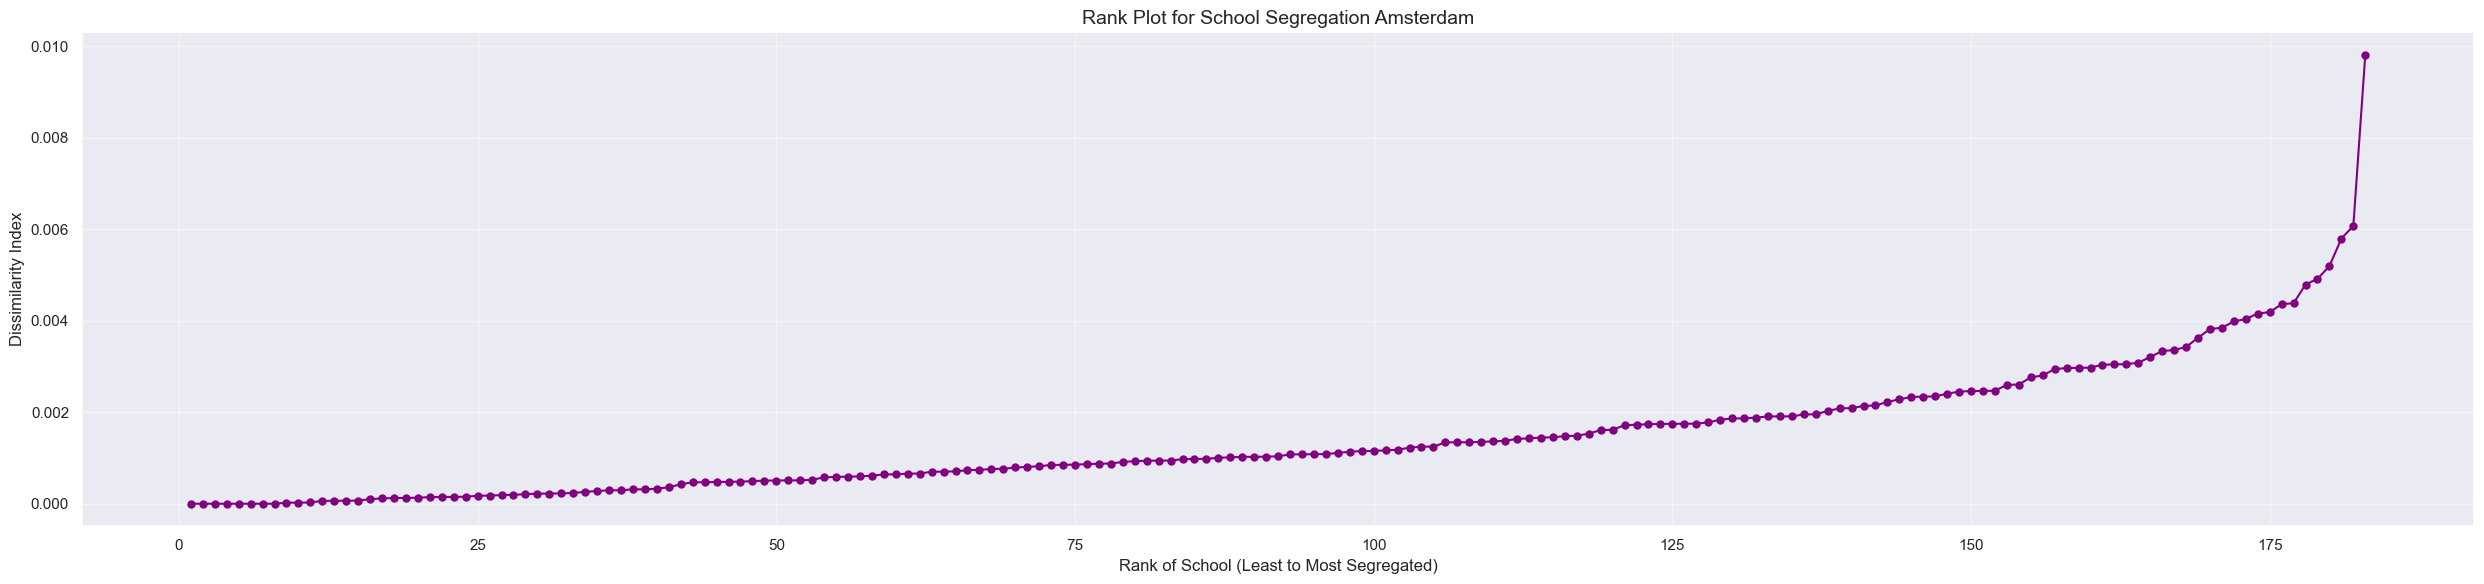

In [28]:
# Sorteren van scholen op basis van de dissimilarity index
scenario_2_dissimilarity = scenario_2.sort_values(by='dissimilarity_index', ascending=True)

# Toevoegen van een rank kolom op basis van de gesorteerde waarden
scenario_2_dissimilarity['rank'] = range(1, len(scenario_2_dissimilarity) + 1)

# Plot maken
plt.figure(figsize=(25, 6))
plt.plot(scenario_2_dissimilarity['rank'], scenario_2_dissimilarity['dissimilarity_index'], marker='o', linestyle='-', markersize=5, color = 'purple')

# Assen labels en titel
plt.xlabel('Rank of School (Least to Most Segregated)', fontsize=12)
plt.ylabel('Dissimilarity Index', fontsize=12)
plt.title('Rank Plot for School Segregation Amsterdam', fontsize=14)

# Grid toevoegen voor betere leesbaarheid
plt.grid(alpha=0.5)

# Plot laten zien
plt.tight_layout()
plt.savefig("rank_scenario2_ams.png", dpi=300, bbox_inches='tight')  # Hoge resolutie
plt.show()




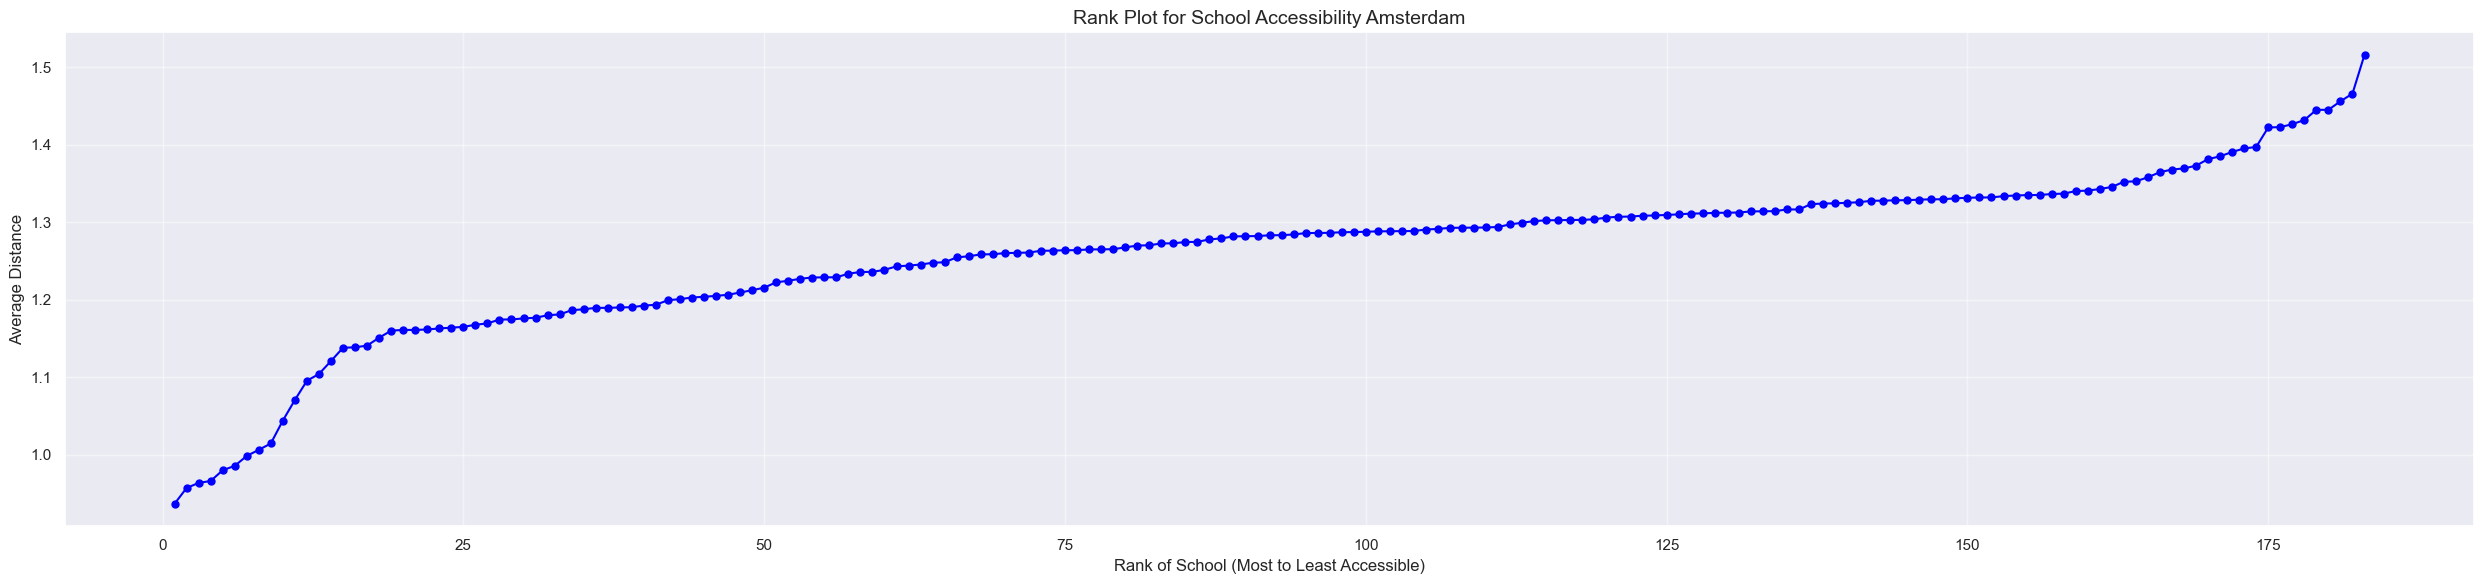

In [29]:
# Sorteren van scholen op basis van de gemiddelde afstand
scenario_2_accessibility = scenario_2.sort_values(by='avg_distance', ascending=True)

# Toevoegen van een rank kolom op basis van de gesorteerde waarden
scenario_2_accessibility['rank'] = range(1, len(scenario_2_accessibility) + 1)

# Plot maken
plt.figure(figsize=(25, 6))
plt.plot(scenario_2_accessibility['rank'], scenario_2_accessibility['avg_distance'], marker='o', linestyle='-', markersize=5, color='blue')

# Assen labels en titel
plt.xlabel('Rank of School (Most to Least Accessible)', fontsize=12)
plt.ylabel('Average Distance', fontsize=12)
plt.title('Rank Plot for School Accessibility Amsterdam', fontsize=14)

# Grid toevoegen voor betere leesbaarheid
plt.grid(alpha=0.5)

# Plot laten zien
plt.tight_layout()
plt.savefig("acc_scenario2_ams.png", dpi=300, bbox_inches='tight')
plt.show()